<a href="https://colab.research.google.com/github/paulocarvalhoprcf/dataset-tcc/blob/main/arquivo3_TCC_2025_Univesp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [ ]:
dados = pd.read_csv('dataset.csv')
dados['Data'] = pd.to_datetime(dados['Data'])
dados.set_index('Data', inplace=True)
dados.head()

,BRL/USD,S&P500,XAU/USD,Crude,CPI,IBOV,IPCA
Data,,,,,,,
1994-07-01,0.9625,446.2,386.95,17.57,148.4,3581,148.4
1994-07-04,0.9350,446.2,386.95,17.47,148.4,3623,148.4
1994-07-05,0.9250,446.4,386.05,17.38,148.4,3581,148.4
1994-07-06,0.9100,446.1,383.95,17.06,148.4,3564,148.4
1994-07-07,0.9080,448.4,384.65,17.08,148.4,3754,148.4


In [ ]:
dados = dados.drop(['BRL/USD', 'XAU/USD', 'Crude', 'CPI', 'IPCA'], axis=1)
dados

,S&P500,IBOV
Data,,
1994-07-01,446.20,3581
1994-07-04,446.20,3623
1994-07-05,446.40,3581
1994-07-06,446.10,3564
1994-07-07,448.40,3754
...,...,...
2024-12-25,6040.04,122105
2024-12-26,6037.59,120767
2024-12-27,5970.84,121078


In [ ]:
# Retornos diários de S&P500
dados['S&P500_returns'] = dados['S&P500'].pct_change()

# Retornos diários de IBOV
dados['IBOV_returns'] = dados['IBOV'].pct_change()

# Volatilidade de S&P500 (desvio padrão dos últimos 12 meses de retornos)
dados['volatility_S&P500'] = dados['S&P500_returns'].rolling(window=262).std()

# Volatilidade de IBOV (desvio padrão dos últimos 12 meses de retornos)
dados['volatility_IBOV'] = dados['IBOV_returns'].rolling(window=262).std()

dados

,S&P500,IBOV,S&P500_returns,IBOV_returns,volatility_S&P500,volatility_IBOV
Data,,,,,,
1994-07-01,446.20,3581,NaN,NaN,NaN,NaN
1994-07-04,446.20,3623,0.000000,0.011729,NaN,NaN
1994-07-05,446.40,3581,0.000448,-0.011593,NaN,NaN
1994-07-06,446.10,3564,-0.000672,-0.004747,NaN,NaN
1994-07-07,448.40,3754,0.005156,0.053311,NaN,NaN
...,...,...,...,...,...,...
2024-12-25,6040.04,122105,0.000000,0.000000,0.007747,0.007906
2024-12-26,6037.59,120767,-0.000406,-0.010958,0.007745,0.007929
2024-12-27,5970.84,121078,-0.011056,0.002575,0.007780,0.007922


In [ ]:
dados['volatility_S&P500'].sum()/dados['volatility_S&P500'].count()

np.float64(0.01075470333463707)

In [ ]:
dados['volatility_IBOV'].sum()/dados['volatility_S&P500'].count()

np.float64(0.018141219643911313)

In [ ]:
dados['S&P500_returns'].idxmax()

Timestamp('2008-10-13 00:00:00')

In [ ]:
dados['S&P500_returns'].max()

0.1158807829181494

In [ ]:
dados['S&P500_returns'].idxmin()

Timestamp('2020-03-16 00:00:00')

In [ ]:
dados['S&P500_returns'].min()

-0.11984507561785318

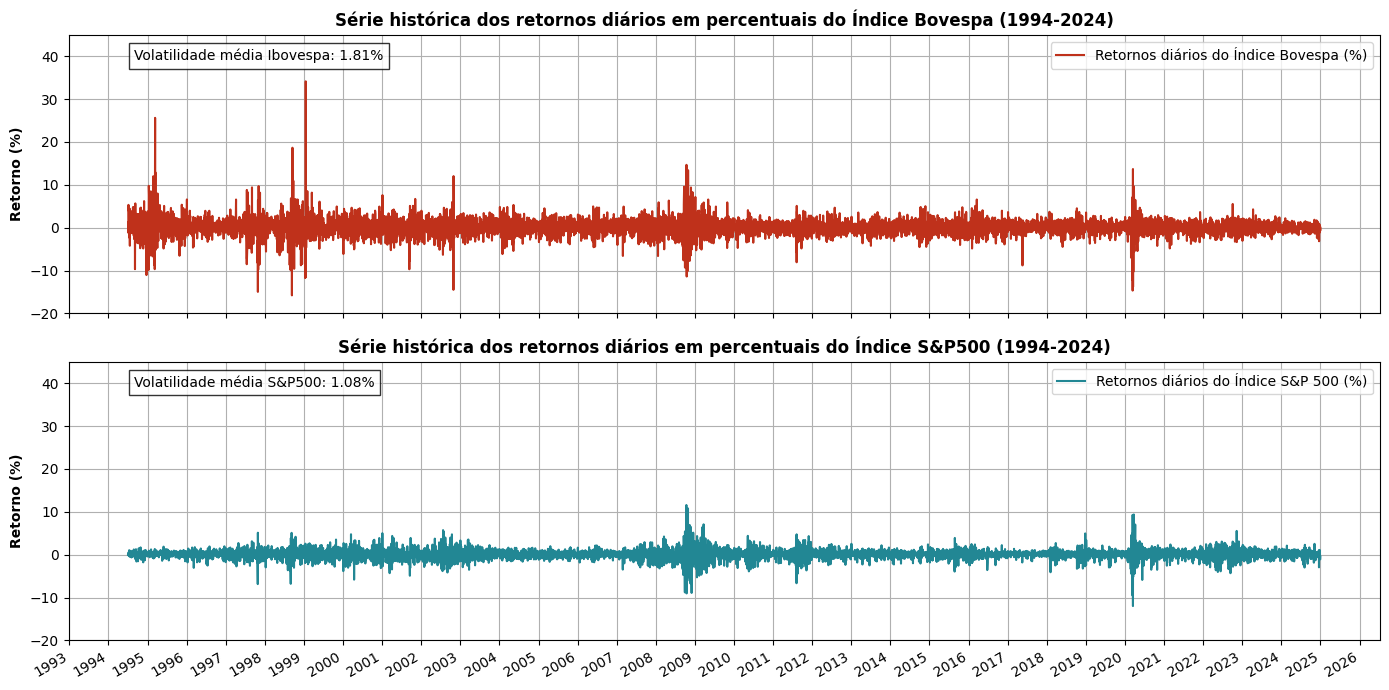

In [ ]:
# Calcula a volatilidade média
vol_media_sp500 = (dados['volatility_S&P500'].sum() / dados['volatility_S&P500'].count())*100
vol_media_ibov = (dados['volatility_IBOV'].sum() / dados['volatility_IBOV'].count())*100

# Cria a figura e os subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True, sharey=True)  # 2 linhas, 1 coluna

# Gráfico 1: Retornos diários do IBOV
ax1.plot(dados.index, dados['IBOV_returns']*100, label='Retornos diários do Índice Bovespa (%)', color='#bf311b')
ax1.set_title('Série histórica dos retornos diários em percentuais do Índice Bovespa (1994-2024)', weight='bold')  # Título do subplot 2
ax1.set_xlabel('Anos', weight='bold')
ax1.set_ylabel('Retorno (%)', weight='bold')
# Define o limite superior do eixo y para 45
ax1.set_ylim(top=45, bottom=-20)
# Adiciona a legenda com a volatilidade média
ax1.text(0.05, 0.95, f'Volatilidade média Ibovespa: {vol_media_ibov:.2f}%',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))
ax1.legend()
ax1.grid(True)

# Gráfico 1: Retornos diários do S&P500
ax2.plot(dados.index, dados['S&P500_returns']*100, label='Retornos diários do Índice S&P 500 (%)', color='#228794')
ax2.set_title('Série histórica dos retornos diários em percentuais do Índice S&P500 (1994-2024)', weight='bold')  # Título do subplot 1
ax2.set_ylabel('Retorno (%)', weight='bold')
# Define o limite superior do eixo y para 45
ax2.set_ylim(top=45, bottom=-20)
# Adiciona a legenda com a volatilidade média
ax2.text(0.05, 0.95, f'Volatilidade média S&P500: {vol_media_sp500:.2f}%',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))
ax2.legend()
ax2.grid(True)

# Ajuste do eixo x (aplicado a ambos os subplots)
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()

# Ajusta o layout e exibe o gráfico
plt.tight_layout()  # Ajusta o espaçamento entre os subplots
plt.savefig('retornos_sp500_ibov_vertical.png')  # Salva a figura
plt.show()

In [ ]:
dados2 = dados.copy()
dados2 = dados2.drop(['S&P500', 'IBOV', 'S&P500_returns', 'IBOV_returns'], axis=1)
dados2.dropna(inplace=True)
dados2

,volatility_S&P500,volatility_IBOV
Data,,
1995-07-04,0.005334,0.038398
1995-07-05,0.005334,0.038397
1995-07-06,0.005381,0.038405
1995-07-07,0.005384,0.038453
1995-07-10,0.005378,0.038381
...,...,...
2024-12-25,0.007747,0.007906
2024-12-26,0.007745,0.007929
2024-12-27,0.007780,0.007922


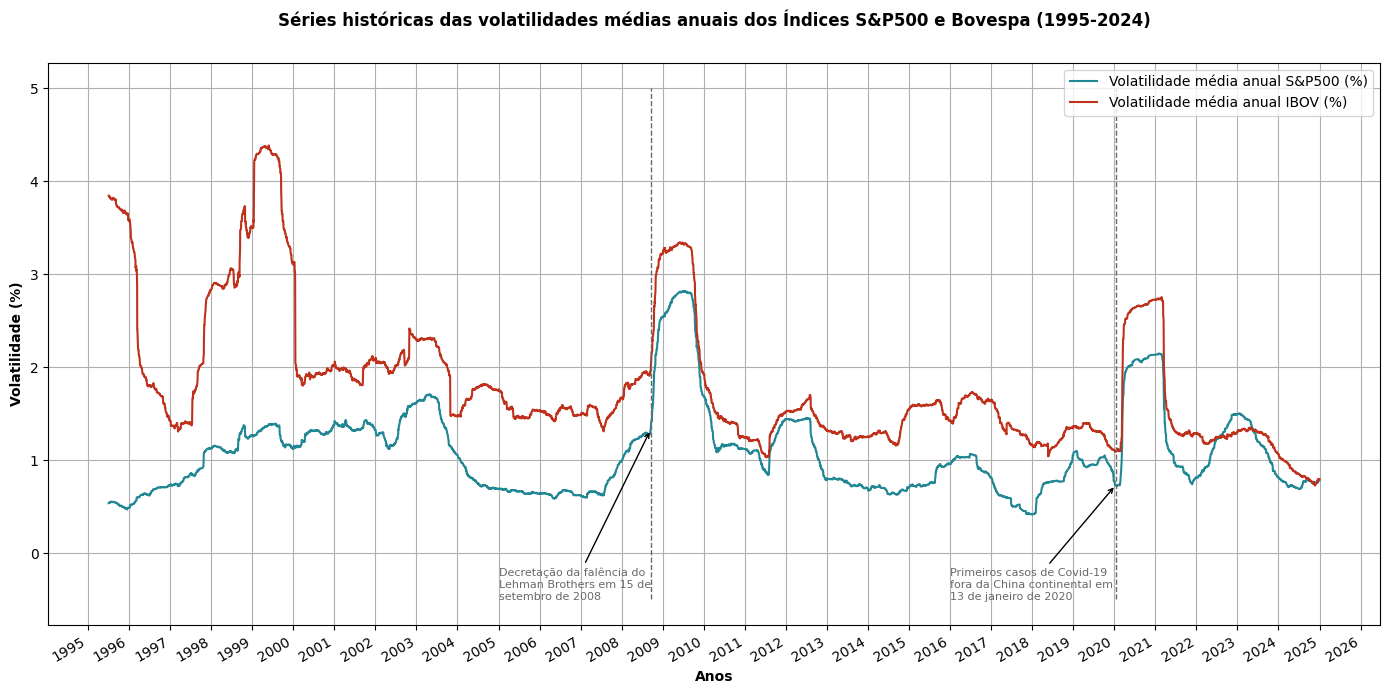

In [ ]:
fig, ax  = plt.subplots(figsize=(14, 7))

plt.plot(dados2.index, dados2['volatility_S&P500']*100, label='Volatilidade média anual S&P500 (%)', linewidth=1.5, color='#228794')
plt.plot(dados2.index, dados2['volatility_IBOV']*100, label='Volatilidade média anual IBOV (%)', linewidth=1.5, color='#bf311b')

annotation_date1 = datetime.datetime(2008, 9, 15)
x_val1 = annotation_date1
y_val1 = dados2.loc[annotation_date1, 'volatility_S&P500'] * 100

# Annotate
plt.annotate('Decretação da falência do\nLehman Brothers em 15 de\nsetembro de 2008',
             xy=(x_val1, y_val1),  # ponto do gráfico
             xytext=(datetime.datetime(2005, 1, 1), -0.5),   # posição do texto
             arrowprops=dict(arrowstyle="->"),
             fontsize=8,
             color='#696969')

annotation_date2 = datetime.datetime(2020, 1, 13)
x_val2 = annotation_date2
y_val2 = dados2.loc[annotation_date2, 'volatility_S&P500'] * 100

plt.annotate('Primeiros casos de Covid-19\nfora da China continental em\n13 de janeiro de 2020',
             xy=(x_val2, y_val2),  # ponto do gráfico
             xytext=(datetime.datetime(2016, 1, 1), -0.5),   # posição do texto
             arrowprops=dict(arrowstyle="->"),
             fontsize=8,
             color='#696969')

# Linhas verticais
plt.vlines(datetime.datetime(2008, 9, 15),-0.5,5.0,linewidth=1,linestyle='--',colors='#696969')
plt.vlines(datetime.datetime(2020, 1, 13),-0.5,5.0,linewidth=1,linestyle='--',colors='#696969')

# Ajuste do eixo x
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Define a frequência dos ticks (ano a ano)
# plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Define ticks menores (mês a mês)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato de data mais legível (Ano)

plt.gcf().autofmt_xdate()  # Rotaciona as labels das datas para evitar sobreposição

ax.set(xlabel='Data', ylabel='Volatilidade média anual (%))')
ax.grid()

plt.xlabel('Anos', fontdict={'fontsize': 10}, weight='bold')
plt.ylabel('Volatilidade (%)', fontdict={'fontsize': 10}, weight='bold')
plt.title('Séries históricas das volatilidades médias anuais dos Índices S&P500 e Bovespa (1995-2024)', weight='bold', y=1.05)
plt.legend()
plt.tight_layout()
plt.savefig('vol_s&p500_ibov.png')
plt.show()

In [ ]:
dados.loc[dados.index[0]:dados.index[100], 'S&P500_returns'].sum()

np.float64(0.035324194597236125)

In [ ]:
dados3 = dados.copy()
dados3

,S&P500,IBOV,S&P500_returns,IBOV_returns,volatility_S&P500,volatility_IBOV
Data,,,,,,
1994-07-01,446.20,3581,NaN,NaN,NaN,NaN
1994-07-04,446.20,3623,0.000000,0.011729,NaN,NaN
1994-07-05,446.40,3581,0.000448,-0.011593,NaN,NaN
1994-07-06,446.10,3564,-0.000672,-0.004747,NaN,NaN
1994-07-07,448.40,3754,0.005156,0.053311,NaN,NaN
...,...,...,...,...,...,...
2024-12-25,6040.04,122105,0.000000,0.000000,0.007747,0.007906
2024-12-26,6037.59,120767,-0.000406,-0.010958,0.007745,0.007929
2024-12-27,5970.84,121078,-0.011056,0.002575,0.007780,0.007922


In [ ]:
window_size = 220  # Janela de observação para identificar picos e vales
threshold = 0.05  # Limiar para definir uma grande queda ou alta (10% no exemplo)

In [ ]:
# Criar listas para armazenar os índices dos picos e vales
picos = []
vales = []

picos.append(dados3['S&P500'].idxmax())
vales.append(dados3['S&P500'].idxmin())

# Iterar sobre os dados
for i in range(window_size, len(dados3) - window_size):
    # Obter a janela de dados atual
    window = dados3['S&P500'][i - window_size:i + window_size]

    # Verificar se o ponto atual é um pico
    if window.iloc[window_size] == window.max():
        # Verificar se há uma queda significativa após o pico
        if (window.iloc[window_size] - window.iloc[window_size:].min()) / window.iloc[window_size] >= threshold:
            picos.append(window.index[window_size])

    # Verificar se o ponto atual é um vale
    if window.iloc[window_size] == window.min():
        # Verificar se há uma alta significativa após o vale
        if (window.iloc[window_size:].max() - window.iloc[window_size]) / window.iloc[window_size] >= threshold:
            vales.append(window.index[window_size])

In [ ]:
print("Picos:", picos)
print("Vales:", vales)

Picos: [Timestamp('2024-12-06 00:00:00'), Timestamp('2000-03-24 00:00:00'), Timestamp('2007-10-09 00:00:00'), Timestamp('2015-05-21 00:00:00'), Timestamp('2022-01-03 00:00:00')]
Vales: [Timestamp('1994-12-08 00:00:00'), Timestamp('2002-10-09 00:00:00'), Timestamp('2009-03-09 00:00:00'), Timestamp('2011-10-03 00:00:00'), Timestamp('2016-02-11 00:00:00'), Timestamp('2018-12-24 00:00:00'), Timestamp('2018-12-25 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2022-10-12 00:00:00')]


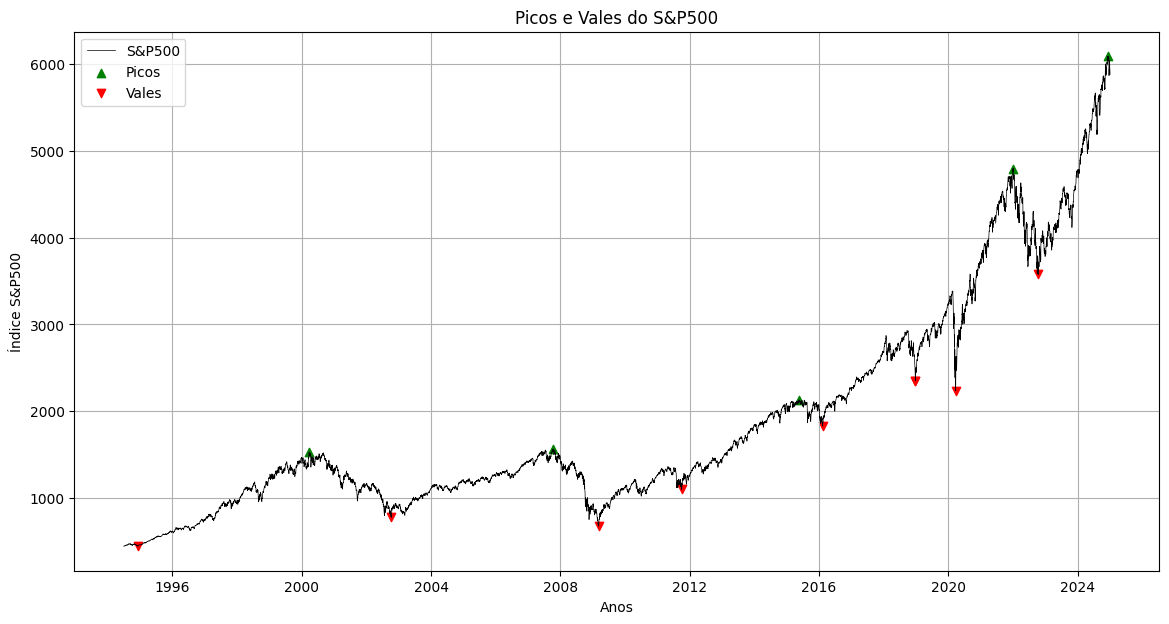

In [ ]:
# Plotar a série histórica do S&P500
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(dados3.index, dados3['S&P500'], label='S&P500', color='black', linewidth=0.5)

# Destacar os picos e vales no gráfico
ax.scatter(picos, dados3['S&P500'][picos], marker='^', color='green', label='Picos')
ax.scatter(vales, dados3['S&P500'][vales], marker='v', color='red', label='Vales')

# # Adicionar faixas cinzas entre vales e picos
# for i in range(min(len(picos), len(vales))):
#     ax.axvspan(vales[i], picos[i], color='gray', alpha=0.3)

# # Adicionar faixas amarelas entre picos e vales
# for i in range(min(len(vales), len(picos))):
#     ax.axvspan(vales[i], picos[i], color='yellow', alpha=0.3)

plt.title('Picos e Vales do S&P500')
plt.xlabel('Anos')
plt.ylabel('Índice S&P500')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Criar a nova coluna 'market_regime_S&P500' e inicializar com 'lateral'
dados3['market_regime_S&P500'] = 'lateral'

# Atribuir etiquetas 'bullish' e 'bearish'
for i in range(min(len(picos), len(vales))):
    # Período bullish: entre um vale e um pico
    dados3.loc[vales[i]:picos[i], 'market_regime_S&P500'] = 'bullish'

    # Período bearish: entre um pico e o próximo vale (se houver)
    if i + 1 < len(vales):
        dados3.loc[picos[i]:vales[i + 1], 'market_regime_S&P500'] = 'bearish'

# Exibir o DataFrame com a nova coluna
dados3

,S&P500,IBOV,S&P500_returns,IBOV_returns,volatility_S&P500,volatility_IBOV,market_regime_S&P500
Data,,,,,,,
1994-07-01,446.20,3581,NaN,NaN,NaN,NaN,lateral
1994-07-04,446.20,3623,0.000000,0.011729,NaN,NaN,lateral
1994-07-05,446.40,3581,0.000448,-0.011593,NaN,NaN,lateral
1994-07-06,446.10,3564,-0.000672,-0.004747,NaN,NaN,lateral
1994-07-07,448.40,3754,0.005156,0.053311,NaN,NaN,lateral
...,...,...,...,...,...,...,...
2024-12-25,6040.04,122105,0.000000,0.000000,0.007747,0.007906,lateral
2024-12-26,6037.59,120767,-0.000406,-0.010958,0.007745,0.007929,lateral
2024-12-27,5970.84,121078,-0.011056,0.002575,0.007780,0.007922,lateral


In [ ]:
dados3['market_regime_S&P500'].value_counts()

,count
market_regime_S&P500,
bullish,4626
bearish,3194
lateral,131


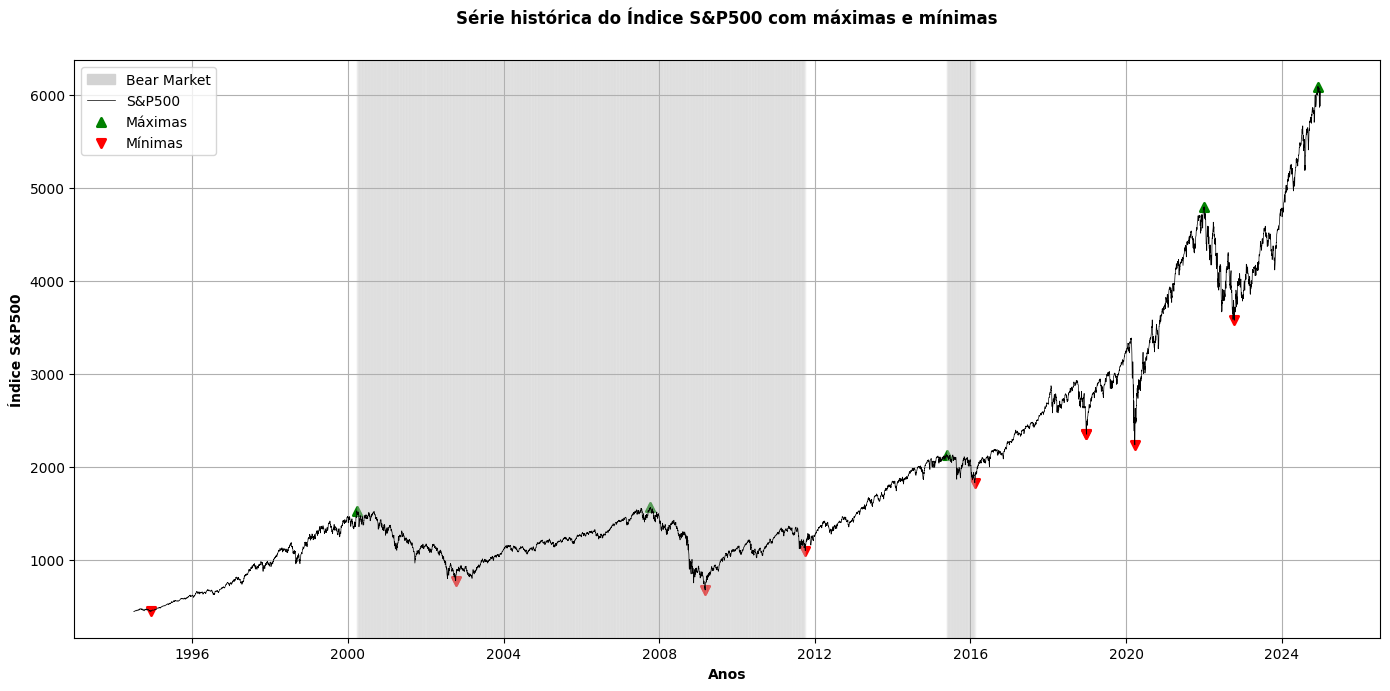

In [ ]:
# Plotar a série histórica do S&P500
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(dados3.index, dados3['S&P500'], label='S&P500', color='black', linewidth=0.5)

# Destacar os picos e vales no gráfico
ax.scatter(picos, dados3['S&P500'][picos], marker='^', color='green', label='Máximas', linewidths=2)
ax.scatter(vales, dados3['S&P500'][vales], marker='v', color='red', label='Mínimas', linewidths=2)

for i in range(1, len(dados3)):
    if dados3['market_regime_S&P500'].iloc[i-1] == 'bearish':
        ax.axvspan(dados3.index[i-1], dados3.index[i], color='lightgray', alpha=0.05)

# Cria uma legenda customizável para tratar dos períodos bearish
bearish_patch = mpatches.Patch(color='lightgray', alpha=1, label='Bear Market')

plt.title('Série histórica do Índice S&P500 com máximas e mínimas', fontdict={'fontsize': 12}, weight='bold', y=1.05)
plt.xlabel('Anos', fontdict={'fontsize': 10}, weight='bold')
plt.ylabel('Índice S&P500', fontdict={'fontsize': 10}, weight='bold')

# Adiciona uma etiqueta bearish à legenda
plt.legend(handles=[bearish_patch] + ax.get_legend_handles_labels()[0])
plt.grid(True)
plt.tight_layout()
plt.savefig('s&p500_max_min_bearish.png')
plt.show()

In [ ]:
dados4 = dados3.copy()
dados4.dropna(inplace=True)
dados4['market_regime_S&P500'] = dados4['market_regime_S&P500'].replace({'lateral': 'bearish'})
dados4

,S&P500,IBOV,S&P500_returns,IBOV_returns,volatility_S&P500,volatility_IBOV,market_regime_S&P500
Data,,,,,,,
1995-07-04,547.10,3594,0.000000,-0.002498,0.005334,0.038398,bullish
1995-07-05,547.30,3634,0.000366,0.011130,0.005334,0.038397,bullish
1995-07-06,554.00,3700,0.012242,0.018162,0.005381,0.038405,bullish
1995-07-07,556.40,3821,0.004332,0.032703,0.005384,0.038453,bullish
1995-07-10,557.20,3962,0.001438,0.036901,0.005378,0.038381,bullish
...,...,...,...,...,...,...,...
2024-12-25,6040.04,122105,0.000000,0.000000,0.007747,0.007906,bearish
2024-12-26,6037.59,120767,-0.000406,-0.010958,0.007745,0.007929,bearish
2024-12-27,5970.84,121078,-0.011056,0.002575,0.007780,0.007922,bearish


In [ ]:
dados4['market_regime_S&P500'].value_counts()

,count
market_regime_S&P500,
bullish,4478
bearish,3211


In [ ]:
# Features: variáveis explicativas (exemplo: retornos e volatilidade)
X = dados4[['S&P500', 'S&P500_returns', 'volatility_S&P500']]

# Target: regimes de mercado
y = dados4['market_regime_S&P500']

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. Aplicação de Modelos de Classificação

(a) Random Forest

In [ ]:
# Modelo de classificação Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Previsão
y_pred_rf = rf_model.predict(X_test_scaled)

# Avaliação do modelo
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division='warn'))
print("Acurácia: %.2f" %(accuracy_score(y_test, y_pred_rf)*100.0) + "%")

Random Forest Classification Report:
              precision    recall  f1-score   support

     bearish       0.92      0.96      0.94       642
     bullish       0.97      0.94      0.96       896

    accuracy                           0.95      1538
   macro avg       0.95      0.95      0.95      1538
weighted avg       0.95      0.95      0.95      1538

Acurácia: 94.93%


SVM (Support Vector Machine)

In [ ]:
# Definir os valores dos hiperparâmetros a serem testados
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5)

# Treinar o modelo com Grid Search
grid_search.fit(X_train_scaled, y_train)

# Obter o melhor modelo
best_svm_model = grid_search.best_estimator_

# Fazer previsões com o melhor modelo
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Avaliar o modelo
print("SVM Classification Report (com Grid Search):")
print(classification_report(y_test, y_pred_svm, zero_division='warn'))
print(f"Acurácia: %.2f" %(accuracy_score(y_test, y_pred_svm)*100.0) + "%")

SVM Classification Report (com Grid Search):
              precision    recall  f1-score   support

     bearish       0.88      0.90      0.89       642
     bullish       0.93      0.91      0.92       896

    accuracy                           0.91      1538
   macro avg       0.90      0.91      0.91      1538
weighted avg       0.91      0.91      0.91      1538

Acurácia: 90.83%


(c) Rede Neural MLP (Multi-layer Perceptron)

In [ ]:
# Modelo de rede neural
mlp_model = MLPClassifier(hidden_layer_sizes=(200, 100), max_iter=1000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Previsão
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Avaliação do modelo
print("MLP Neural Network Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print(f"Acurácia: %.2f" %(accuracy_score(y_test, y_pred_mlp)*100.0) + "%")

MLP Neural Network Classification Report:
              precision    recall  f1-score   support

     bearish       0.88      0.95      0.91       642
     bullish       0.96      0.91      0.93       896

    accuracy                           0.93      1538
   macro avg       0.92      0.93      0.92      1538
weighted avg       0.93      0.93      0.93      1538

Acurácia: 92.59%


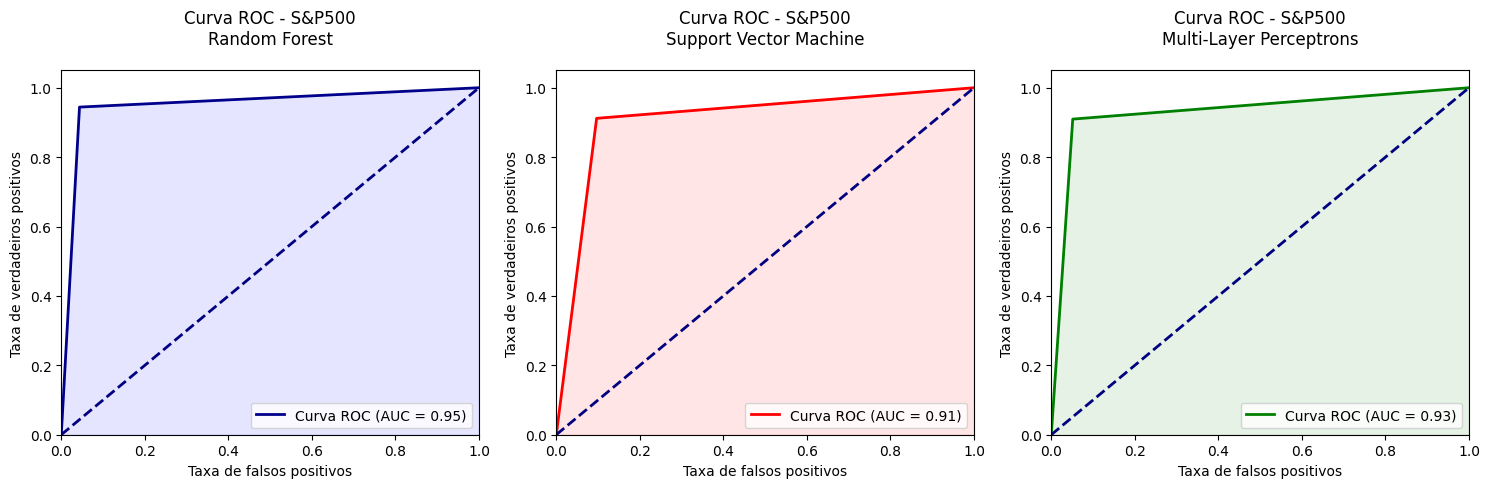

In [ ]:
# Curva ROC (Receiver Operating Characteristic)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Random Forest
# Calcular a curva ROC e a AUC
# Converter y_test e y_pred_rf em valores binários
y_test_binary = y_test.map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
y_pred_rf_binary = pd.Series(y_pred_rf).map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_rf_binary)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
axes[0].plot(fpr, tpr, color='darkblue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].fill_between(fpr, tpr, color='blue', alpha=0.1)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Taxa de falsos positivos')
axes[0].set_ylabel('Taxa de verdadeiros positivos')
axes[0].set_title('Curva ROC - S&P500\nRandom Forest', y=1.05)
axes[0].legend(loc="lower right")

# SVM
# Support Vector Machine
# Calcular a curva ROC e a AUC
# Converter y_test e y_pred_svm em valores binários
y_test_binary = y_test.map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
y_pred_svm_binary = pd.Series(y_pred_svm).map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_svm_binary)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
axes[1].plot(fpr, tpr, color='red', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].fill_between(fpr, tpr, color='red', alpha=0.1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Taxa de falsos positivos')
axes[1].set_ylabel('Taxa de verdadeiros positivos')
axes[1].set_title('Curva ROC - S&P500\nSupport Vector Machine', y=1.05)
axes[1].legend(loc="lower right")

# MLP
# Multi-Layer Perceptrons
# Calcular a curva ROC e a AUC
# Converter y_test e y_pred_svm em valores binários
y_test_binary = y_test.map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
y_pred_mlp_binary = pd.Series(y_pred_mlp).map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_mlp_binary)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
axes[2].plot(fpr, tpr, color='green', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2].fill_between(fpr, tpr, color='green', alpha=0.1)
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Taxa de falsos positivos')
axes[2].set_ylabel('Taxa de verdadeiros positivos')
axes[2].set_title('Curva ROC - S&P500\nMulti-Layer Perceptrons', y=1.05)
axes[2].legend(loc="lower right")

plt.tight_layout()
plt.savefig('s&p500_market_regime_ROC_curve.png')
plt.show()

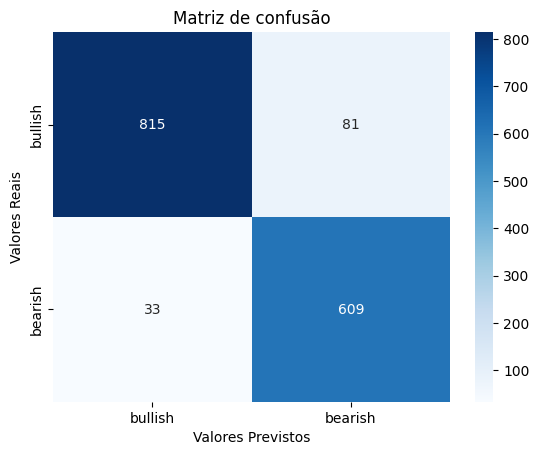

In [ ]:
# Definir os rótulos originais
labels = ['bullish', 'bearish']

# Criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred_mlp, labels=labels)

# Plotar a matriz de confusão com seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de confusão')
plt.show()

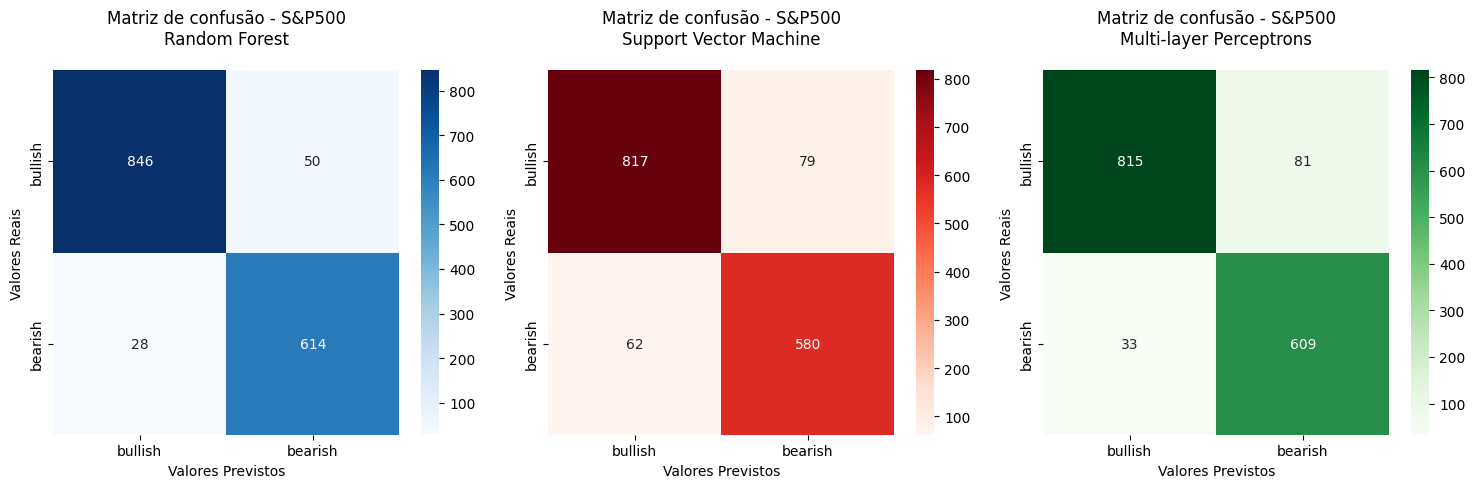

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Definir os rótulos originais
labels = ['bullish', 'bearish']

# Random Forest
# Criar a matriz de confusão
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)

# Plotar a matriz de confusão com seaborn
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=labels, yticklabels=labels)
axes[0].set_xlabel('Valores Previstos')
axes[0].set_ylabel('Valores Reais')
axes[0].set_title('Matriz de confusão - S&P500\nRandom Forest', y=1.05)

# SVM
# Criar a matriz de confusão
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)

# Plotar a matriz de confusão com seaborn
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', ax=axes[1], xticklabels=labels, yticklabels=labels)
axes[1].set_xlabel('Valores Previstos')
axes[1].set_ylabel('Valores Reais')
axes[1].set_title('Matriz de confusão - S&P500\nSupport Vector Machine', y=1.05)

# MLP
# Criar a matriz de confusão
cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=labels)

# Plotar a matriz de confusão com seaborn
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens', ax=axes[2], xticklabels=labels, yticklabels=labels)
axes[2].set_xlabel('Valores Previstos')
axes[2].set_ylabel('Valores Reais')
axes[2].set_title('Matriz de confusão - S&P500\nMulti-layer Perceptrons', y=1.05)

plt.tight_layout()
plt.savefig('s&p500_market_regime_confusion_matrix.png')
plt.show()

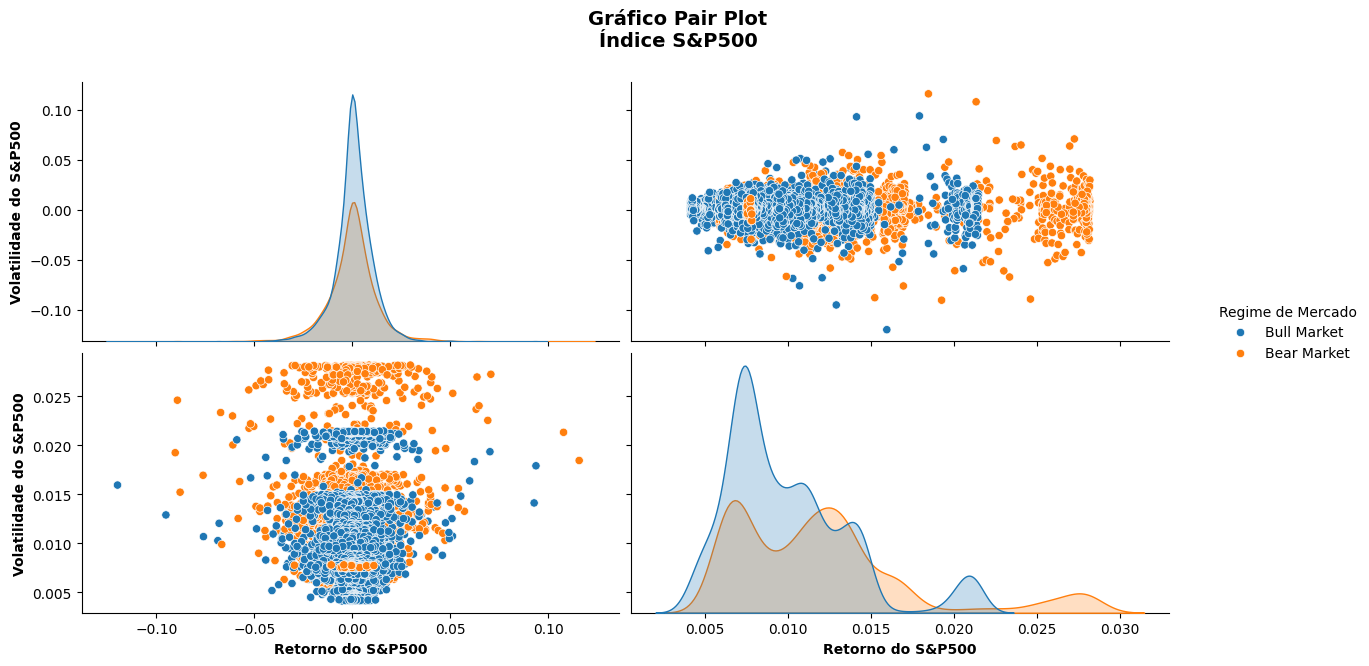

In [ ]:
# Pair Plot

sns.pairplot(dados4[['S&P500_returns', 'volatility_S&P500', 'market_regime_S&P500']],
             vars=['S&P500_returns', 'volatility_S&P500'],
             hue = 'market_regime_S&P500',
             height=3,
             aspect=2)

# Customizando os rótulos dos eixos e os títulos das legendas
plt.gcf().axes[0].set_ylabel("Volatilidade do S&P500", weight='bold')  # Set ylabel for the first subplot
plt.gcf().axes[2].set_ylabel("Volatilidade do S&P500", weight='bold')  # Set ylabel for the third subplot
plt.gcf().axes[2].set_xlabel("Retorno do S&P500", weight='bold')  # Set xlabel for the third subplot
plt.gcf().axes[3].set_xlabel("Retorno do S&P500", weight='bold')  # Set xlabel for the fourth subplot

# Acessando a legenda e alterando o seu título
fig = plt.gcf()
legend = fig.legends[0]  # Access the first legend in the figure
legend.set_title('Regime de Mercado')  # Set title directly using the Legend object

# Modificando os rótulos das legendas, se necessário (opcional)
for text in legend.texts:
    text.set_text(text.get_text().replace("bullish", "Bull Market").replace("bearish", "Bear Market"))

plt.suptitle('Gráfico Pair Plot\nÍndice S&P500', fontsize=14, y=1.1, weight='bold')
plt.savefig('pairplot_regimes_mercado_S&P500.png')
plt.show()

In [ ]:
window_size = 120  # Janela de observação para identificar picos e vales
threshold = 0.05  # Limiar para definir uma grande queda ou alta (10% no exemplo)

In [ ]:
# Criar listas para armazenar os índices dos picos e vales
picos = []
vales = []

picos.append(dados3['IBOV'].idxmax())
vales.append(dados3['IBOV'].idxmin())

# Iterar sobre os dados
for i in range(window_size, len(dados3) - window_size):
    # Obter a janela de dados atual
    window = dados3['IBOV'][i - window_size:i + window_size]

    # Verificar se o ponto atual é um pico
    if window.iloc[window_size] == window.max():
        # Verificar se há uma queda significativa após o pico
        if (window.iloc[window_size] - window.iloc[window_size:].min()) / window.iloc[window_size] >= threshold:
            picos.append(window.index[window_size])

    # Verificar se o ponto atual é um vale
    if window.iloc[window_size] == window.min():
        # Verificar se há uma alta significativa após o vale
        if (window.iloc[window_size:].max() - window.iloc[window_size]) / window.iloc[window_size] >= threshold:
            vales.append(window.index[window_size])


In [ ]:
print("Picos:", picos)
print("Vales:", vales)

Picos: [Timestamp('2024-08-29 00:00:00'), Timestamp('1997-07-10 00:00:00'), Timestamp('1998-04-16 00:00:00'), Timestamp('1999-05-14 00:00:00'), Timestamp('2000-03-28 00:00:00'), Timestamp('2001-01-29 00:00:00'), Timestamp('2002-03-05 00:00:00'), Timestamp('2004-01-27 00:00:00'), Timestamp('2005-03-07 00:00:00'), Timestamp('2006-05-10 00:00:00'), Timestamp('2008-05-21 00:00:00'), Timestamp('2008-05-22 00:00:00'), Timestamp('2010-04-09 00:00:00'), Timestamp('2010-11-05 00:00:00'), Timestamp('2012-03-14 00:00:00'), Timestamp('2013-01-04 00:00:00'), Timestamp('2013-10-23 00:00:00'), Timestamp('2014-09-03 00:00:00'), Timestamp('2015-05-06 00:00:00'), Timestamp('2017-02-22 00:00:00'), Timestamp('2018-02-27 00:00:00'), Timestamp('2020-01-24 00:00:00'), Timestamp('2021-06-08 00:00:00'), Timestamp('2022-04-04 00:00:00'), Timestamp('2022-10-24 00:00:00'), Timestamp('2023-12-28 00:00:00'), Timestamp('2023-12-29 00:00:00'), Timestamp('2024-01-01 00:00:00')]
Vales: [Timestamp('1995-03-10 00:00:00')

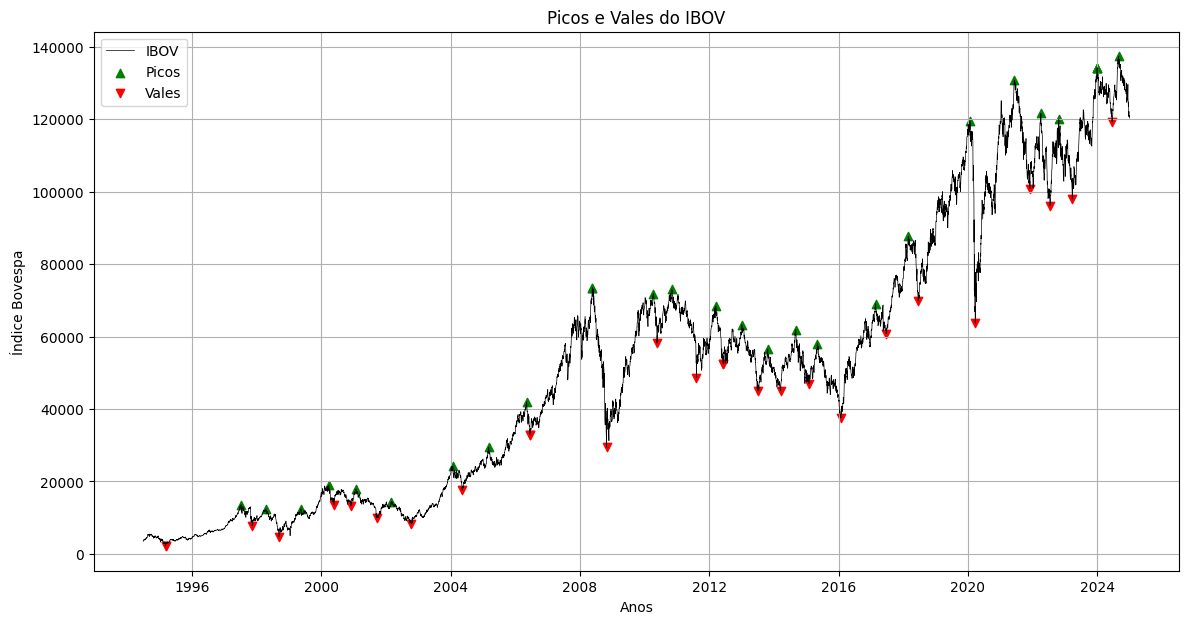

In [ ]:
# Plotar a série histórica do IBOV
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(dados3.index, dados3['IBOV'], label='IBOV', color='black', linewidth=0.5)

# Destacar os picos e vales no gráfico
ax.scatter(picos, dados3['IBOV'][picos], marker='^', color='green', label='Picos')
ax.scatter(vales, dados3['IBOV'][vales], marker='v', color='red', label='Vales')

# # Adicionar faixas cinzas entre vales e picos
# for i in range(min(len(picos), len(vales))):
#     ax.axvspan(vales[i], picos[i], color='gray', alpha=0.3)

# # Adicionar faixas amarelas entre picos e vales
# for i in range(min(len(vales), len(picos))):
#     ax.axvspan(vales[i], picos[i], color='yellow', alpha=0.3)

plt.title('Picos e Vales do IBOV')
plt.xlabel('Anos')
plt.ylabel('Índice Bovespa')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Criar a nova coluna 'market_regime_IBOV' e inicializar com 'lateral'
dados3['market_regime_IBOV'] = 'lateral'

# Atribuir etiquetas 'bullish' e 'bearish'
for i in range(min(len(picos), len(vales))):
    # Período bullish: entre um vale e um pico
    dados3.loc[vales[i]:picos[i], 'market_regime_IBOV'] = 'bullish'

    # Período bearish: entre um pico e o próximo vale (se houver)
    if i + 1 < len(vales):
        dados3.loc[picos[i]:vales[i + 1], 'market_regime_IBOV'] = 'bearish'

# Exibir o DataFrame com a nova coluna
dados3

,S&P500,IBOV,S&P500_returns,IBOV_returns,volatility_S&P500,volatility_IBOV,market_regime_S&P500,market_regime_IBOV
Data,,,,,,,,
1994-07-01,446.20,3581,NaN,NaN,NaN,NaN,lateral,lateral
1994-07-04,446.20,3623,0.000000,0.011729,NaN,NaN,lateral,lateral
1994-07-05,446.40,3581,0.000448,-0.011593,NaN,NaN,lateral,lateral
1994-07-06,446.10,3564,-0.000672,-0.004747,NaN,NaN,lateral,lateral
1994-07-07,448.40,3754,0.005156,0.053311,NaN,NaN,lateral,lateral
...,...,...,...,...,...,...,...,...
2024-12-25,6040.04,122105,0.000000,0.000000,0.007747,0.007906,lateral,lateral
2024-12-26,6037.59,120767,-0.000406,-0.010958,0.007745,0.007929,lateral,lateral
2024-12-27,5970.84,121078,-0.011056,0.002575,0.007780,0.007922,lateral,lateral


In [ ]:
dados3['market_regime_IBOV'].value_counts()

,count
market_regime_IBOV,
bullish,4111
bearish,3572
lateral,268


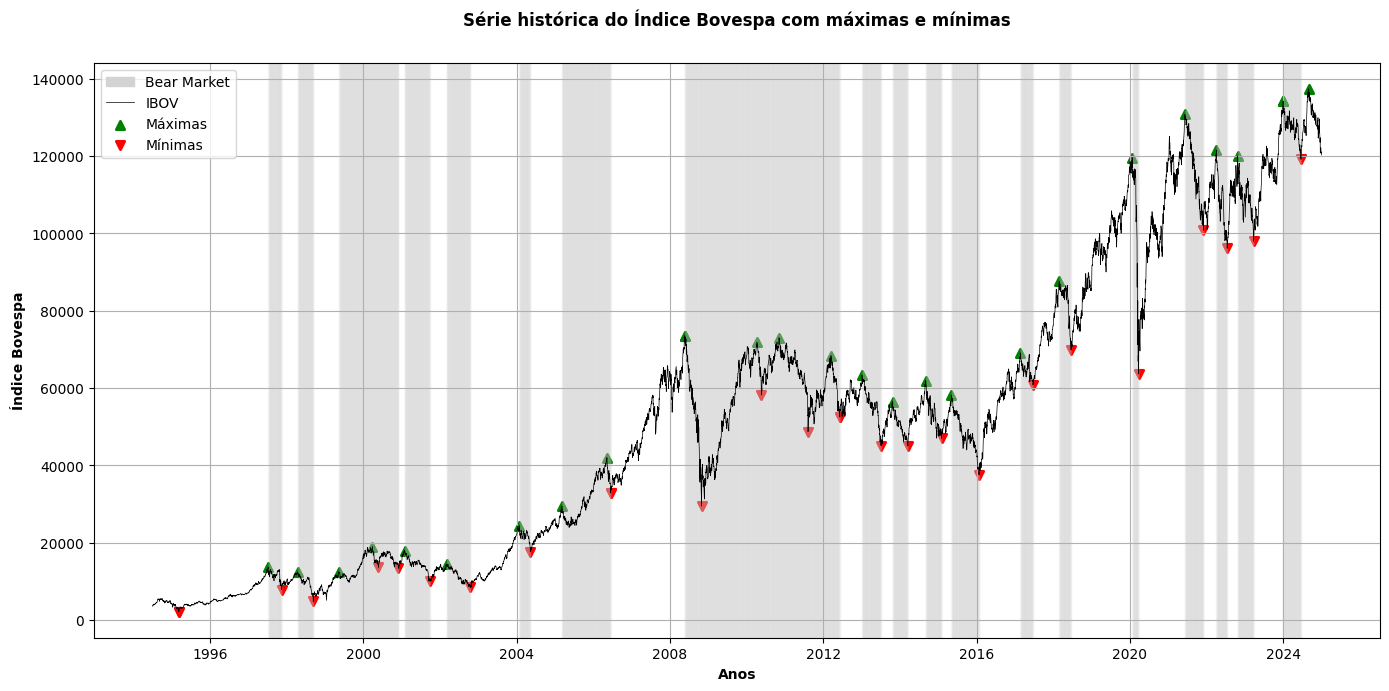

In [ ]:
# Plotar a série histórica do IBOV
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(dados3.index, dados3['IBOV'], label='IBOV', color='black', linewidth=0.5)

# Destacar os picos e vales no gráfico
ax.scatter(picos, dados3['IBOV'][picos], marker='^', color='green', label='Máximas', linewidths=2)
ax.scatter(vales, dados3['IBOV'][vales], marker='v', color='red', label='Mínimas', linewidths=2)

for i in range(1, len(dados3)):
    if dados3['market_regime_IBOV'].iloc[i-1] == 'bearish':
        ax.axvspan(dados3.index[i-1], dados3.index[i], color='lightgray', alpha=0.05)

# Cria uma legenda customizável para tratar dos períodos bearish
bearish_patch = mpatches.Patch(color='lightgray', alpha=1, label='Bear Market')

plt.title('Série histórica do Índice Bovespa com máximas e mínimas', fontdict={'fontsize': 12}, weight='bold', y=1.05)
plt.xlabel('Anos', fontdict={'fontsize': 10}, weight='bold')
plt.ylabel('Índice Bovespa', fontdict={'fontsize': 10}, weight='bold')

# Adiciona uma etiqueta bearish à legenda
plt.legend(handles=[bearish_patch] + ax.get_legend_handles_labels()[0])
plt.grid(True)
plt.tight_layout()
plt.savefig('ibov_max_min_bearish.png')
plt.show()

In [ ]:
dados5 = dados3.copy()
dados5.dropna(inplace=True)
dados5['market_regime_IBOV'] = dados5['market_regime_IBOV'].replace({'lateral': 'bearish'})
dados5

,S&P500,IBOV,S&P500_returns,IBOV_returns,volatility_S&P500,volatility_IBOV,market_regime_S&P500,market_regime_IBOV
Data,,,,,,,,
1995-07-04,547.10,3594,0.000000,-0.002498,0.005334,0.038398,bullish,bullish
1995-07-05,547.30,3634,0.000366,0.011130,0.005334,0.038397,bullish,bullish
1995-07-06,554.00,3700,0.012242,0.018162,0.005381,0.038405,bullish,bullish
1995-07-07,556.40,3821,0.004332,0.032703,0.005384,0.038453,bullish,bullish
1995-07-10,557.20,3962,0.001438,0.036901,0.005378,0.038381,bullish,bullish
...,...,...,...,...,...,...,...,...
2024-12-25,6040.04,122105,0.000000,0.000000,0.007747,0.007906,lateral,bearish
2024-12-26,6037.59,120767,-0.000406,-0.010958,0.007745,0.007929,lateral,bearish
2024-12-27,5970.84,121078,-0.011056,0.002575,0.007780,0.007922,lateral,bearish


In [ ]:
dados5['market_regime_IBOV'].value_counts()

,count
market_regime_IBOV,
bullish,4029
bearish,3660


In [ ]:
# Features: variáveis explicativas (exemplo: retornos e volatilidade)
X = dados5[['IBOV', 'IBOV_returns', 'volatility_IBOV']]

# Target: regimes de mercado
y = dados5['market_regime_IBOV']

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. Aplicação de Modelos de Classificação

(a) Random Forest

In [ ]:
# Modelo de classificação Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Previsão
y_pred_rf = rf_model.predict(X_test_scaled)

# Avaliação do modelo
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division='warn'))
print("Acurácia: %.2f" %(accuracy_score(y_test, y_pred_rf)*100.0) + "%")

Random Forest Classification Report:
              precision    recall  f1-score   support

     bearish       0.85      0.86      0.86       732
     bullish       0.88      0.87      0.87       806

    accuracy                           0.87      1538
   macro avg       0.87      0.87      0.87      1538
weighted avg       0.87      0.87      0.87      1538

Acurácia: 86.54%


SVM (Support Vector Machine)

In [ ]:
# Definir os valores dos hiperparâmetros a serem testados
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5)

# Treinar o modelo com Grid Search
grid_search.fit(X_train_scaled, y_train)

# Obter o melhor modelo
best_svm_model = grid_search.best_estimator_

# Fazer previsões com o melhor modelo
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Avaliar o modelo
print("SVM Classification Report (com Grid Search):")
print(classification_report(y_test, y_pred_svm, zero_division='warn'))
print(f"Acurácia: %.2f" %(accuracy_score(y_test, y_pred_svm)*100.0) + "%")

SVM Classification Report (com Grid Search):
              precision    recall  f1-score   support

     bearish       0.79      0.79      0.79       732
     bullish       0.81      0.81      0.81       806

    accuracy                           0.80      1538
   macro avg       0.80      0.80      0.80      1538
weighted avg       0.80      0.80      0.80      1538

Acurácia: 80.10%


(c) Rede Neural MLP (Multi-layer Perceptron)

In [ ]:
# Modelo de rede neural
mlp_model = MLPClassifier(hidden_layer_sizes=(200, 100), max_iter=1000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Previsão
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Avaliação do modelo
print("MLP Neural Network Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print(f"Acurácia: %.2f" %(accuracy_score(y_test, y_pred_mlp)*100.0) + "%")

MLP Neural Network Classification Report:
              precision    recall  f1-score   support

     bearish       0.81      0.82      0.81       732
     bullish       0.83      0.82      0.83       806

    accuracy                           0.82      1538
   macro avg       0.82      0.82      0.82      1538
weighted avg       0.82      0.82      0.82      1538

Acurácia: 81.92%


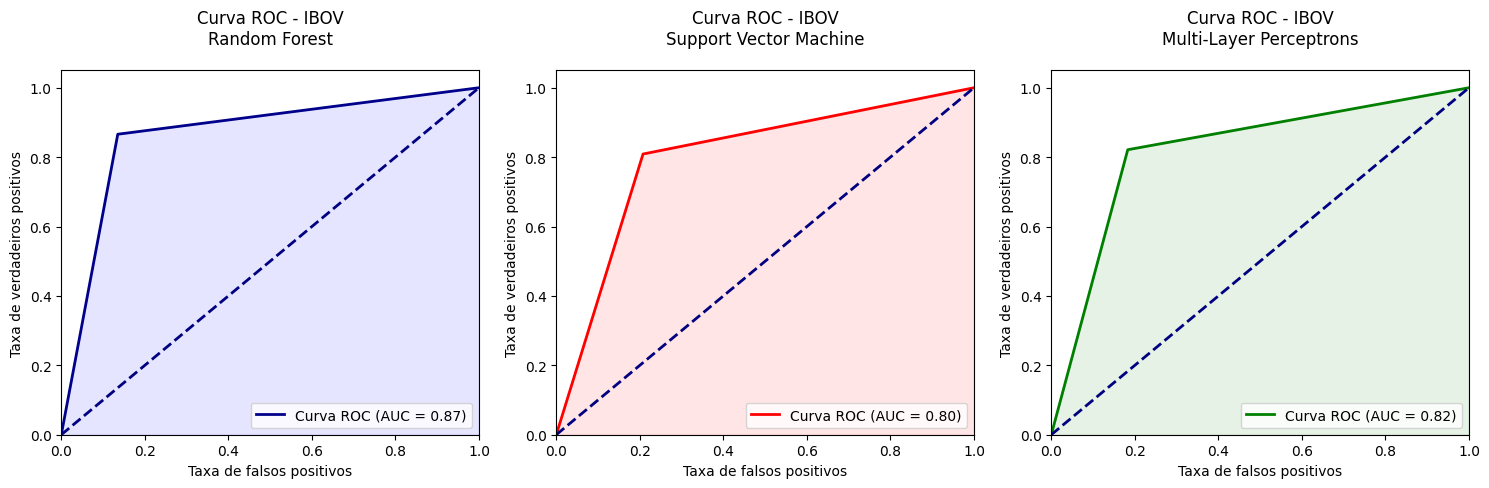

In [ ]:
# Curva ROC (Receiver Operating Characteristic)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Random Forest
# Calcular a curva ROC e a AUC
# Converter y_test e y_pred_rf em valores binários
y_test_binary = y_test.map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
y_pred_rf_binary = pd.Series(y_pred_rf).map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_rf_binary)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
axes[0].plot(fpr, tpr, color='darkblue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].fill_between(fpr, tpr, color='blue', alpha=0.1)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Taxa de falsos positivos')
axes[0].set_ylabel('Taxa de verdadeiros positivos')
axes[0].set_title('Curva ROC - IBOV\nRandom Forest', y=1.05)
axes[0].legend(loc="lower right")

# SVM
# Support Vector Machine
# Calcular a curva ROC e a AUC
# Converter y_test e y_pred_svm em valores binários
y_test_binary = y_test.map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
y_pred_svm_binary = pd.Series(y_pred_svm).map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_svm_binary)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
axes[1].plot(fpr, tpr, color='red', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].fill_between(fpr, tpr, color='red', alpha=0.1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Taxa de falsos positivos')
axes[1].set_ylabel('Taxa de verdadeiros positivos')
axes[1].set_title('Curva ROC - IBOV\nSupport Vector Machine', y=1.05)
axes[1].legend(loc="lower right")

# MLP
# Multi-Layer Perceptrons
# Calcular a curva ROC e a AUC
# Converter y_test e y_pred_svm em valores binários
y_test_binary = y_test.map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
y_pred_mlp_binary = pd.Series(y_pred_mlp).map({'bullish': 1, 'bearish': 0}) # Converter 'bullish' em 1 e 'bearish' em 0
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_mlp_binary)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
axes[2].plot(fpr, tpr, color='green', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2].fill_between(fpr, tpr, color='green', alpha=0.1)
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Taxa de falsos positivos')
axes[2].set_ylabel('Taxa de verdadeiros positivos')
axes[2].set_title('Curva ROC - IBOV\nMulti-Layer Perceptrons', y=1.05)
axes[2].legend(loc="lower right")

plt.tight_layout()
plt.savefig('ibov_market_regime_ROC_curve.png')
plt.show()

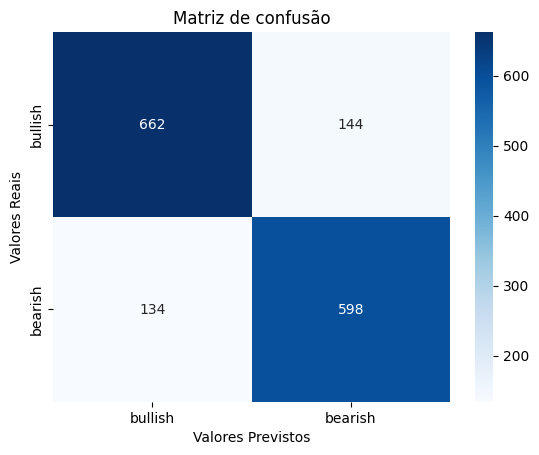

In [ ]:
# Definir os rótulos originais
labels = ['bullish', 'bearish']

# Criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred_mlp, labels=labels)

# Plotar a matriz de confusão com seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de confusão')
plt.show()

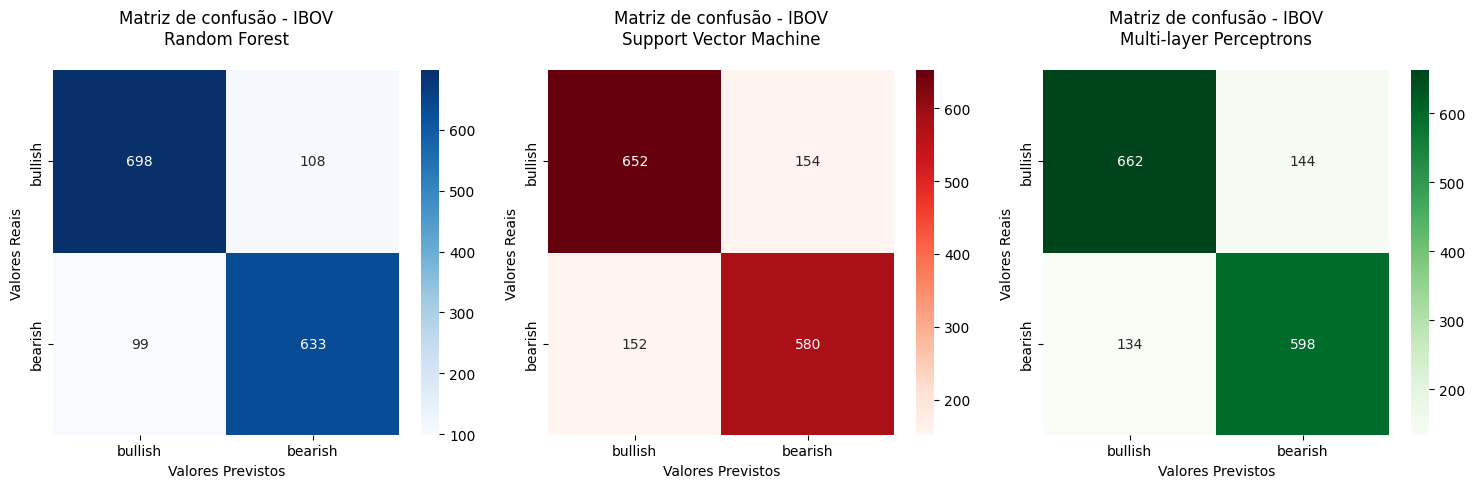

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Definir os rótulos originais
labels = ['bullish', 'bearish']

# Random Forest
# Criar a matriz de confusão
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)

# Plotar a matriz de confusão com seaborn
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=labels, yticklabels=labels)
axes[0].set_xlabel('Valores Previstos')
axes[0].set_ylabel('Valores Reais')
axes[0].set_title('Matriz de confusão - IBOV\nRandom Forest', y=1.05)

# SVM
# Criar a matriz de confusão
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)

# Plotar a matriz de confusão com seaborn
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', ax=axes[1], xticklabels=labels, yticklabels=labels)
axes[1].set_xlabel('Valores Previstos')
axes[1].set_ylabel('Valores Reais')
axes[1].set_title('Matriz de confusão - IBOV\nSupport Vector Machine', y=1.05)

# MLP
# Criar a matriz de confusão
cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=labels)

# Plotar a matriz de confusão com seaborn
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens', ax=axes[2], xticklabels=labels, yticklabels=labels)
axes[2].set_xlabel('Valores Previstos')
axes[2].set_ylabel('Valores Reais')
axes[2].set_title('Matriz de confusão - IBOV\nMulti-layer Perceptrons', y=1.05)

plt.tight_layout()
plt.savefig('ibov_market_regime_confusion_matrix.png')
plt.show()

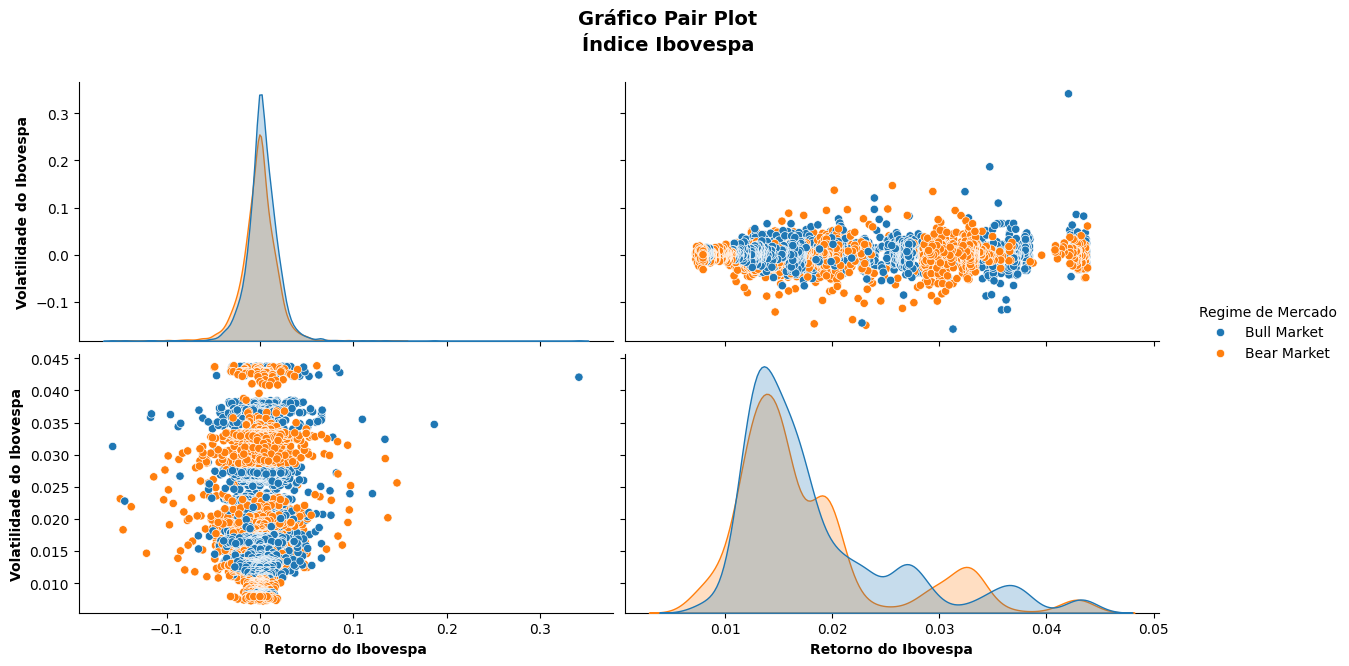

In [ ]:
# Pair Plot

sns.pairplot(dados5[['IBOV_returns', 'volatility_IBOV', 'market_regime_IBOV']],
             vars=['IBOV_returns', 'volatility_IBOV'],
             hue = 'market_regime_IBOV',
             height=3,
             aspect=2)

# Customizando os rótulos dos eixos e os títulos das legendas
plt.gcf().axes[0].set_ylabel("Volatilidade do Ibovespa", weight='bold')  # Set ylabel for the first subplot
plt.gcf().axes[2].set_ylabel("Volatilidade do Ibovespa", weight='bold')  # Set ylabel for the third subplot
plt.gcf().axes[2].set_xlabel("Retorno do Ibovespa", weight='bold')  # Set xlabel for the third subplot
plt.gcf().axes[3].set_xlabel("Retorno do Ibovespa", weight='bold')  # Set xlabel for the fourth subplot

# Acessando a legenda e alterando o seu título
fig = plt.gcf()
legend = fig.legends[0]  # Access the first legend in the figure
legend.set_title('Regime de Mercado')  # Set title directly using the Legend object

# Modificando os rótulos das legendas, se necessário (opcional)
for text in legend.texts:
    text.set_text(text.get_text().replace("bullish", "Bull Market").replace("bearish", "Bear Market"))

plt.suptitle('Gráfico Pair Plot\nÍndice Ibovespa', fontsize=14, y=1.1, weight='bold')
plt.savefig('pairplot_regimes_mercado_IBOV.png')
plt.show()